In [1]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
from typing import List

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
GDRIVE_BASE = "/content/drive" #@param
DATAFRAME_PATH = "/MyDrive/amazon_rainforest_files/monthly_large.csv" #@param
RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/" #@param

def get_dataframe_path_from_params() -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{DATAFRAME_PATH}"

def get_model_save_location(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{MODEL_SAVE_LOCATION}{filename}"

def get_raster_path_from_params(filename) -> str:
  root = GDRIVE_BASE if GDRIVE_BASE else ""
  return f"{root}{RASTER_BASE}{filename}"

In [2]:
# Access data stored on Google Drive
if GDRIVE_BASE:
    from google.colab import drive
    drive.mount(GDRIVE_BASE)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

#Data preparation

We prepare 2 sets of data: One for training for variances and one for training for means. Partition both into labels and test data.

Group on sample site to acquire variances and means.

In [60]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(get_dataframe_path_from_params())

group_on = ['sample_site_lon', 'sample_site_lat', 'month_of_year']
grouped = df.groupby(group_on)

# ASSUMPTION: Taking the mean and variance of a sample site doesn't lower quality of the data.
# We need to do this to use KL-divergence loss.
means = grouped.mean()
O18_var = grouped.var()['cellulose_oxygen_ratio']

# Merging results in some unreadable column names. Rename the oxygen columns.
merged = pd.merge(means, O18_var, on=group_on, how='inner').reset_index()
merged = merged.rename(columns={
    'cellulose_oxygen_ratio_x': 'O18_mean',
    'cellulose_oxygen_ratio_y' : 'O18_var'})

# ...and drop sample_site_lon/sample_site_lat. These were keys used to identify
# sample sites. They are basically duplicates of the 'lat' 'lon' columns.
merged.drop(merged.columns[merged.columns.str.contains('unnamed',case = False)], axis = 1, inplace = True)
merged.drop('sample_site_lon', axis = 1, inplace = True)
merged.drop('sample_site_lat', axis = 1, inplace = True)

# Categorize months into 12 separate binary columns.
def categorize_months(df: pd.DataFrame):
  return pd.get_dummies(df, columns=['month_of_year'])
merged = categorize_months(merged)

train, test = train_test_split(merged, test_size=0.25, random_state=25)

# Target data: Mean and variance
Y_train_means = train[["O18_mean"]]
Y_test_means = test[["O18_mean"]]

Y_train_vars = train[["O18_var"]]
Y_test_vars = test[["O18_var"]]

# Features: Everything besides mean and variance
train.drop(train.columns[train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
X_train_means = train.drop(["O18_mean"], axis=1)
X_test_means = test.drop(["O18_mean"], axis=1)
X_train_vars = train.drop(["O18_var"], axis=1)
X_test_vars = test.drop(["O18_var"], axis=1)

# Normalize dataset for training variances.
X_train_vars = (X_train_vars-X_train_vars.min())/(X_train_vars.max()-X_train_vars.min())
X_test_vars = (X_test_vars-X_test_vars.min())/(X_test_vars.max()-X_train_vars.min())

# Deep neural network for prediction mean O18 ratios

In [61]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt

def train_means(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float):
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='sigmoid'))

    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    for shared_layer in shared_layers:
        x = shared_layer(x)

    # Output is mean. Connect to shared nodes.
    mean_output_layer = layers.Dense(1, activation='linear', name='mean_output')
    mean_output_node = mean_output_layer(x)

    model = keras.Model(inputs=inputs, outputs=[mean_output_node])

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')
    print (model.summary())
    history = model.fit(X, Y, epochs=epochs, verbose=False, batch_size=batch_size, validation_split=0.2, shuffle=True)
    return history, model

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 19)]              0         
                                                                 
 dense_55 (Dense)            (None, 24)                480       
                                                                 
 dense_56 (Dense)            (None, 40)                1000      
                                                                 
 mean_output (Dense)         (None, 1)                 41        
                                                                 
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
None


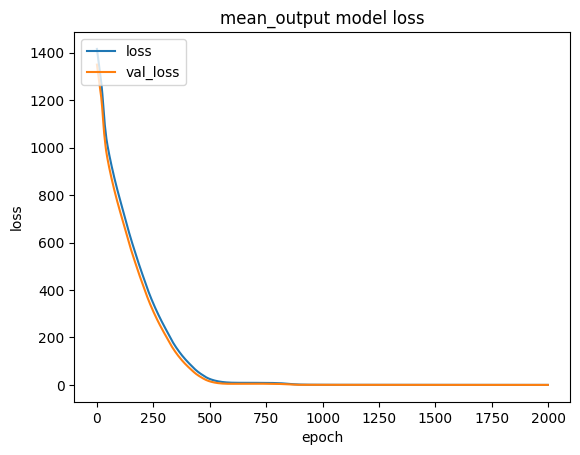

2/2 [==============================] - 0s 6ms/step - loss: 0.1252


0.12518246471881866

In [64]:
# Train and render results.
history, means_model = train_means(X_train_means, Y_train_means, hidden_layers=[24, 40], epochs=2000, batch_size=5, lr = 0.0001)
render_plot_loss(history, "mean_output")
means_model.evaluate(x=X_test_means, y=Y_test_means)

# A seperate model for variances

Experiment with 3 different KL diverge loss functions.

In [45]:
def kl_divergence_loss_1(real, predicted):
    real_value = tf.gather(real, [0], axis=1)
    real_variance = tf.gather(real, [1], axis=1) + 0.00000001
    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_variance = tf.gather(predicted, [1], axis=1) + 0.00000001

    kl_loss = -0.5 + tf.math.log(predicted_variance/real_variance) + \
     (tf.square(real_variance) + tf.square(real_value - predicted_value))/ \
     2*tf.square(predicted_variance)

    return tf.math.reduce_mean(tf.square(kl_loss))

def kl_divergence_loss_v2(real, predicted):
    kl_loss = real * tf.math.log(real/predicted)
    return tf.math.reduce_mean(kl_loss)

# Similar architecture to means, but with different activation functions and
# dropout layers.
def train_vars(
        X: pd.DataFrame,
        Y: pd.DataFrame,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float):
    shared_layers = []
    for num_nodes in hidden_layers:
        shared_layers.append(layers.Dense(
            num_nodes,
            activation='sigmoid'))

    #Initialize input layers and connect them to shared layers.
    num_inputs = X.shape[1]
    inputs = keras.Input(shape=(num_inputs,))
    x = inputs
    x = layers.Dropout(0.5, input_shape=(num_inputs,))(x)
    for shared_layer in shared_layers:
        x = shared_layer(x)


    variance_output_layer = layers.Dense(1, activation='relu', name='variance_output')
    variance_output_node = variance_output_layer(x)

    model = keras.Model(inputs=inputs, outputs=[variance_output_node])

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='kl_divergence')
    print (model.summary())
    history = model.fit(X, Y, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=0.3, shuffle=True)
    return history, model

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 8)]               0         
                                                                 
 dropout_71 (Dropout)        (None, 8)                 0         
                                                                 
 dense_51 (Dense)            (None, 45)                405       
                                                                 
 dense_52 (Dense)            (None, 80)                3680      
                                                                 
 variance_output (Dense)     (None, 1)                 81        
                                                                 
Total params: 4,166
Trainable params: 4,166
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f72fce36050>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


10/10 [==============================] - 88s 25ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 9/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 10/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4610 - val_loss: 0.4098
Epoch 11/500
10/10 

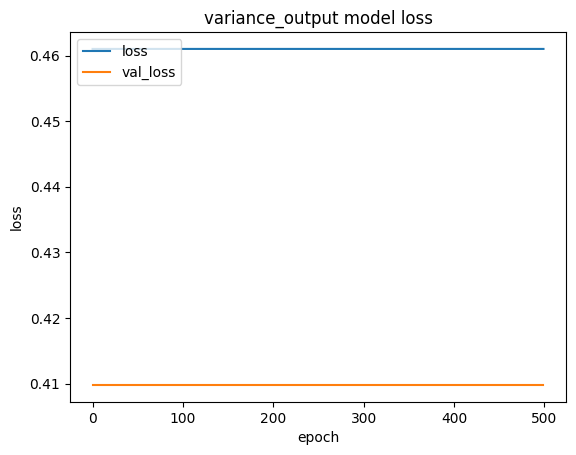

In [47]:
history, vars_model = train_vars(X_train_vars, Y_train_vars, hidden_layers=[45, 80], epochs=500, batch_size=10, lr = 0.0001)
render_plot_loss(history, "variance_output")

In [42]:
vars_model.evaluate(x=X_test_vars, y=Y_test_vars)
predictions = vars_model.predict_on_batch(X_test_vars)
print(predictions)
print (Y_test_vars)

2/2 [==============================] - 0s 6ms/step - loss: -0.0846


[[2.9597337]
 [2.9339566]
 [2.925772 ]
 [3.0071592]
 [3.0405445]
 [2.9223697]
 [2.9219298]
 [2.9597948]
 [2.9019043]
 [2.9213705]
 [2.938408 ]
 [3.0038757]
 [3.0162168]
 [2.9668455]
 [2.9142795]
 [3.0004056]
 [2.921167 ]
 [2.9304695]
 [2.9206212]
 [2.9576385]
 [2.9255314]
 [2.9445148]
 [2.9336953]
 [2.9143424]
 [2.9153602]
 [2.9504528]
 [2.9189992]
 [2.960596 ]
 [2.9112585]
 [2.9552617]
 [2.9161558]
 [2.9392195]
 [2.926196 ]
 [2.936514 ]
 [2.941115 ]
 [2.9388323]
 [2.9536538]
 [2.914215 ]
 [3.0591378]
 [2.9227638]
 [3.0218692]
 [2.9771724]
 [2.9341102]
 [2.9419255]
 [2.9253693]]
      O18_var
85   0.014559
42   0.071723
43   0.228581
40   0.018479
75   0.039620
93   0.032913
21   0.002653
133  0.016409
103  0.005222
141  0.020221
125  0.028953
112  0.033238
26   0.005034
121  0.004556
105  0.016612
99   0.047273
161  0.019221
30   0.005090
80   0.066812
65   0.043063
149  0.011584
145  0.047647
6    0.001341
31   0.002074
163  0.010867
34   0.010581
114  0.018391
41   0.029624
174  0.0

In [23]:
means_model.save(get_model_save_location("dnn_means.h5"), save_format="h5")

In [ ]:
vars_model.save(get_model_save_location("dnn_vars.h5"), save_format="h5")

## Generating GeoTIFFs from the DNN

All of the code from the following block is (temporarily) copy and pasted from the library files.

In [ ]:
from dataclasses import dataclass
from osgeo import gdal, gdal_array
from tqdm import tqdm
import math

@dataclass
class AmazonGeoTiff:
  """Represents a geotiff from our dataset."""
  gdal_dataset: gdal.Dataset
  image_value_array: np.ndarray # ndarray of floats
  image_mask_array: np.ndarray # ndarray of uint8
  masked_image: np.ma.masked_array
  yearly_masked_image: np.ma.masked_array


@dataclass
class Bounds:
  """Represents geographic bounds and size information."""
  minx: float
  maxx: float
  miny: float
  maxy: float
  pixel_size_x: float
  pixel_size_y: float
  raster_size_x: float
  raster_size_y: float

def to_matplotlib(self) -> List[float]:
    return [self.minx, self.maxx, self.miny, self.maxy]

def load_raster(path: str, use_only_band_index: int = -1) -> AmazonGeoTiff:
  """
  TODO: Refactor (is_single_band, etc., should be a better design)
  --> Find a way to simplify this logic. Maybe it needs to be more abstract.
  """
  dataset = gdal.Open(path, gdal.GA_ReadOnly)
  image_datatype = dataset.GetRasterBand(1).DataType
  mask_datatype = dataset.GetRasterBand(1).GetMaskBand().DataType
  image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                   dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
  mask = np.zeros((dataset.RasterYSize, dataset.RasterXSize, 12),
                  dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))

  if use_only_band_index == -1:
    if dataset.RasterCount != 12 and dataset.RasterCount != 1:
      raise ValueError(f"Expected 12 raster bands (one for each month) or one annual average, but found {dataset.RasterCount}")
    if dataset.RasterCount == 1:
      use_only_band_index = 0

  is_single_band = use_only_band_index != -1

  if is_single_band and use_only_band_index >= dataset.RasterCount:
    raise IndexError(f"Specified raster band index {use_only_band_index}"
                     f" but there are only {dataset.RasterCount} rasters")

  for band_index in range(12):
    band = dataset.GetRasterBand(use_only_band_index+1 if is_single_band else band_index+1)
    image[:, :, band_index] = band.ReadAsArray()
    mask[:, :, band_index] = band.GetMaskBand().ReadAsArray()
  masked_image = np.ma.masked_where(mask == 0, image)
  yearly_masked_image = masked_image.mean(axis=2)

  return AmazonGeoTiff(dataset, image, mask, masked_image, yearly_masked_image)

def get_extent(dataset):
  geoTransform = dataset.GetGeoTransform()
  minx = geoTransform[0]
  maxy = geoTransform[3]
  maxx = minx + geoTransform[1] * dataset.RasterXSize
  miny = maxy + geoTransform[5] * dataset.RasterYSize
  return Bounds(minx, maxx, miny, maxy, geoTransform[1], geoTransform[5], dataset.RasterXSize, dataset.RasterYSize)

def coords_to_indices(bounds: Bounds, x: float, y: float):
  if x < bounds.minx or x > bounds.maxx or y < bounds.miny or y > bounds.maxy:
    raise ValueError("Coordinates out of bounds")

  # X => lat, Y => lon
  x_idx = bounds.raster_size_y - int(math.ceil((y - bounds.miny) / abs(bounds.pixel_size_y)))
  y_idx = int((x - bounds.minx) / abs(bounds.pixel_size_x))

  return x_idx, y_idx

def get_data_at_coords(dataset: AmazonGeoTiff, x: float, y: float, month: int) -> float:
  # x = longitude
  # y = latitude
  bounds = get_extent(dataset.gdal_dataset)
  x_idx, y_idx = coords_to_indices(bounds, x, y)
  if month == -1:
    value = dataset.yearly_masked_image[x_idx, y_idx]
  else:
    value = dataset.masked_image[x_idx, y_idx, month]
  if np.ma.is_masked(value):
    raise ValueError("Coordinates are masked")
  else:
    return value


The following code is new stuff, and used to generate a 12 GeoTIFFs (one for each month) from the model.

In [ ]:
def get_predictions_at_each_pixel(
    monthly: bool,
    geotiffs: dict[str, AmazonGeoTiff],
    bounds: Bounds,
    model: keras.Model):

  # Initialize a blank plane representing means and variance.
  predicted_means_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))
  predicted_vars_np = np.ma.array(
      np.zeros([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=float),
      mask=np.ones([bounds.raster_size_x, bounds.raster_size_y, 12 if monthly else 1], dtype=bool))

  feature_names = ["lat", "lon", "month_of_year"] + list(geotiffs.keys())
  for month in range (0, 12 if monthly else 1):
    for x_idx, x in enumerate(tqdm(np.arange(bounds.minx, bounds.maxx, bounds.pixel_size_x, dtype=float))):
      rows = []
      row_indexes = []
      for y_idx, y in enumerate(np.arange(bounds.miny, bounds.maxy, -bounds.pixel_size_y, dtype=float)):
        row = {}
        try:
          for geotiff_label, geotiff in geotiffs.items():
            row[geotiff_label] = get_data_at_coords(geotiff, x, y, month)
          row["month_of_year"] = month
          row["lon"] = x
          row["lat"] = y
        except ValueError:
          continue # masked and out-of-bounds coordinates
        except IndexError:
          continue
        rows.append(row)
        row_indexes.append((y_idx,month,))
      if (len(rows) > 0):
        X = pd.DataFrame.from_dict(rows)
        predictions = model.predict_on_batch(X)

        means_np = predictions[0]
        for prediction, (y_idx, month_idx) in zip(means_np, row_indexes):
          predicted_means_np.mask[x_idx,y_idx,month_idx] = False # unmask since we have data
          predicted_means_np.data[x_idx,y_idx,month_idx] = prediction
        vars_np = predictions[1]
        for prediction, (y_idx, month_idx) in zip (vars_np, row_indexes):
          predicted_vars_np.mask[x_idx, y_idx, month_idx] = False
          predicted_vars_np.data[x_idx, y_idx, month_idx] = prediction

  return predicted_means_np, predicted_vars_np

In [ ]:
from tensorflow import keras
model = keras.models.load_model(get_model_save_location(), custom_objects={"kl_divergence_loss": kl_divergence_loss})

relative_humidity_geotiff = load_raster(get_raster_path_from_params("R.rh_Stack.tif"))
temperature_geotiff = load_raster(get_raster_path_from_params("Temperatura_Stack.tif"))
vapor_pressure_deficit_geotiff = load_raster(get_raster_path_from_params("R.vpd_Stack.tif"))
atmosphere_isoscape_geotiff = load_raster(get_raster_path_from_params("Iso_Oxi_Stack.tif"))

name_to_geotiff = {
    "rh": relative_humidity_geotiff,
    "temp" : temperature_geotiff,
    "vpd" : vapor_pressure_deficit_geotiff,
    "atmosphere_oxygen_ratio" : atmosphere_isoscape_geotiff,
}

# We need the borders of the map. Pick one geotiff at random and use that as the extent.
bounds =  get_extent(atmosphere_isoscape_geotiff.gdal_dataset)

means_np, vars_np = get_predictions_at_each_pixel(
    monthly=True,
    geotiffs=name_to_geotiff,
    bounds=bounds,
    model=model)

100%|██████████| 940/940 [00:33<00:00, 27.96it/s]
